# TCN on Multiple Electrodes


This notebook is a proof of concept work for running TCNs on multiple electrodes. It is based on Eric Ham's work and on Bai et al.

In [ ]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [28]:
# Imports
import numpy as np
import string
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import sys
sys.path.append('../')
from brain2brain import utils

In [29]:
# Get all file_paths for patient 625
file_paths = utils.get_file_paths(625)

In [ ]:
ecogs = utils.create_ecog_array(file_paths, True)

Reading /projects/HASSON/247/data/625-conversations/NY625_418-419_Part1_conversation1/NY625_418-419_Part1_conversation1.npy
Finished reading /projects/HASSON/247/data/625-conversations/NY625_418-419_Part1_conversation1/NY625_418-419_Part1_conversation1.npy. Loaded into numpy array of shape (247460, 98)
Added rows to ecogs. Ecogs size: 1
Reading /projects/HASSON/247/data/625-conversations/NY625_418-419_Part1_conversation2/NY625_418-419_Part1_conversation2.npy
Finished reading /projects/HASSON/247/data/625-conversations/NY625_418-419_Part1_conversation2/NY625_418-419_Part1_conversation2.npy. Loaded into numpy array of shape (69077, 98)
Added rows to ecogs. Ecogs size: 2
Reading /projects/HASSON/247/data/625-conversations/NY625_418-419_Part1_conversation4/NY625_418-419_Part1_conversation4.npy
Finished reading /projects/HASSON/247/data/625-conversations/NY625_418-419_Part1_conversation4/NY625_418-419_Part1_conversation4.npy. Loaded into numpy array of shape (192201, 98)
Added rows to ecogs

In [ ]:
ecogs.shape

In [23]:
# Load patient data
data = np.load("/projects/HASSON/247/data/625-conversations/NY625_420_Part6_conversation1/NY625_420_Part6_conversation1.npy")

In [24]:
data

array([[  34.71443534,    3.58127871,   -0.98091271, ..., -101.73178115,
         -36.25727312,  -70.14234797],
       [  37.67167214,    9.05546553,   -6.47073932, ...,  -98.38837723,
         -42.42399306,  -69.56880489],
       [  39.47857797,   15.10714477,  -12.03648992, ...,  -94.67567675,
         -48.70193101,  -68.46768645],
       ...,
       [   3.32768073,    6.44208625,   -1.43961943, ..., -109.46831071,
         -88.25238891,  -55.73488824],
       [  -1.12344955,    6.55080872,   -3.80005689, ..., -115.16248735,
         -90.31095086,  -51.098763  ],
       [  -5.87691698,    6.41104345,   -6.65966428, ..., -119.99802577,
         -91.10151044,  -45.50820385]])

In [37]:
float_data = data

In [41]:
len(float_data[0])

98

Given data going as far back as `lookback` timesteps (a timestep is a 512th of a second), and sampled every `steps` timesteps, can you predict the value in `delay` timesteps?

In this problem, we are also seeking to see if we can use more than one electrode at a time to predict the next value.

In [4]:
data.shape

(560786, 98)

We have 98 electrodes and 560786 timesteps. This is about 1000 seconds.

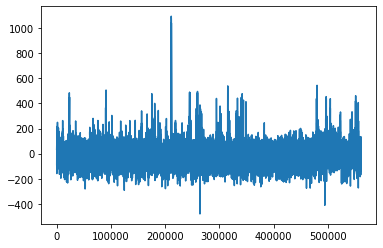

In [5]:
# Plot one electrode
signal = data[:,0]
plt.plot(range(len(signal)), signal)

In [6]:
# Preparing the data (normalization)
# Axis=0 refers to rows. Rows are signal samples.
# 307200 = 512 * 10 * 60 (first ten minutes)
mean = float_data[:307200].mean(axis=0)
float_data -= mean
std = float_data[:307200].std(axis=0)
float_data /= std

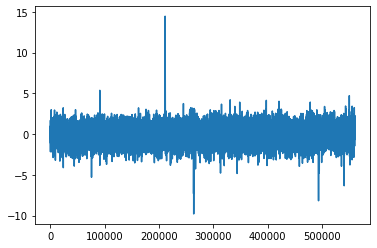

In [108]:
# Plot one electrode (after normalization)
signal = float_data[:,2]
plt.plot(range(len(signal)), signal)

In [86]:
# Generator (see Deep Learning with Python pag. 211)
# data - the original array of floating-point data.
# lookback - How many timesteps back the input data should go.
# delay - How many timesteps in the future the target should be.
# min_index and max_index - Indices in the data arr that delimit which time steps to draw from. 
#     This is useful for splitting the data in training, validation, and test.
# shuffle - Whether to shuffle the samples or draw them in chronological order.
# batch_size - The number of samples per batch.
# step - The period, in timesteps, at which you sample data. 
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index == None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback,
                                     max_index,
                                     size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step, 
                           data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield (samples, targets)

In [87]:
# Preparing the training, validation, and test generators
lookback = 5120 # Observations will go back 10s.
step = 128 # Observations will be sampled at 4 data points per second.
delay = 256 # Targets are 0.5s in the future.
batch_size = 64 # Number of samples per batch.

In [88]:
# Generate training data.
train_gen = generator(float_data, 
                      lookback=lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 307200,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

In [89]:
# Generate validation data.
val_gen = generator(float_data, 
                    lookback=lookback,
                    delay = delay,
                    min_index = 307201,
                    max_index = 407200,
                    step = step,
                    batch_size = batch_size)

In [90]:
# Generate test data.
test_gen = generator(float_data, 
                      lookback=lookback,
                      delay = delay,
                      min_index = 407201,
                      max_index = None,
                      step = step,
                      batch_size = batch_size)

In [58]:
# How many steps to draw from val_gen in order to see the entire validation set.
val_steps = (407200 - 307201 - lookback)
# How many steps to draw from test_gen in order to see the entire test set.
test_steps = (len(float_data) - 407201 - lookback)

In [59]:
print(val_steps)

94879


In [61]:
# Computing the common-sense baseline MAE
# Assume that signal .5s from now is going to be the same
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(f"MAE Mean is: {np.mean(batch_maes)}")
evaluate_naive_method()

MAE Mean is: 1.048459937123424


In [104]:
unit = 1.04 * std[1]
unit 

76.98671606379752

In [67]:
# Basic ML Approach (Baseline)
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step,
                                      float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs = 20,
                              validation_data=val_gen,
                              validation_steps=val_steps // batch_size)

Epoch 1/20
500/500 [==============================] - 15s 30ms/step - loss: 0.9730 - val_loss: 0.8901
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.6060 - val_loss: 0.8415
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.5209 - val_loss: 0.8877
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4648 - val_loss: 0.8763
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4192 - val_loss: 0.8467
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3891 - val_loss: 0.9260
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3596 - val_loss: 0.9154
Epoch 8/20
500/500 [==============================] - 16s 31ms/step - loss: 0.3373 - val_loss: 0.8632
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3177 - val_loss: 0.8781
Epoch 10/20
500/500 [==============================] - 16s 31ms/step - loss: 0.303

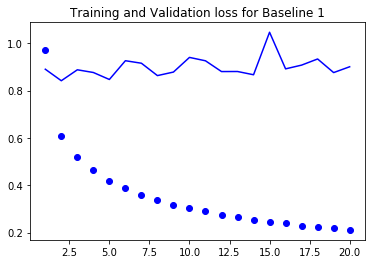

In [68]:
# Plotting Baseline Results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss,'b', label='Validation Loss')
plt.title("Training and Validation loss for Baseline 1")
plt.show()

In [95]:
# A first recurrent baseline
model = Sequential()
model.add(layers.GRU(48, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history=model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data = val_gen,
                             validation_steps = val_steps // batch_size)

Epoch 1/20
500/500 [==============================] - 21s 42ms/step - loss: 0.7291 - val_loss: 0.8185
Epoch 2/20
500/500 [==============================] - 22s 44ms/step - loss: 0.6827 - val_loss: 0.7990
Epoch 3/20
500/500 [==============================] - 22s 45ms/step - loss: 0.6609 - val_loss: 0.8520
Epoch 4/20
500/500 [==============================] - 22s 44ms/step - loss: 0.6261 - val_loss: 0.9660
Epoch 5/20
500/500 [==============================] - 22s 44ms/step - loss: 0.6036 - val_loss: 0.8887
Epoch 6/20
500/500 [==============================] - 22s 45ms/step - loss: 0.5846 - val_loss: 0.9103
Epoch 7/20
500/500 [==============================] - 22s 45ms/step - loss: 0.5603 - val_loss: 0.9860
Epoch 8/20
500/500 [==============================] - 22s 44ms/step - loss: 0.5420 - val_loss: 0.9133
Epoch 9/20
500/500 [==============================] - 22s 43ms/step - loss: 0.5329 - val_loss: 0.8621
Epoch 10/20
500/500 [==============================] - 22s 43ms/step - loss: 0.519

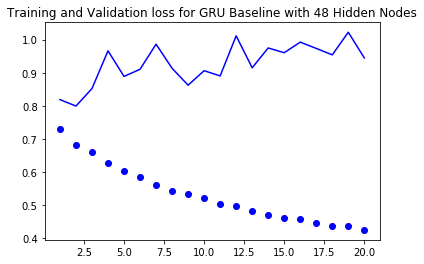

In [96]:
# Plotting Baseline Results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss,'b', label='Validation Loss')
plt.title("Training and Validation loss for GRU Baseline with 48 Hidden Nodes")
plt.show()

In [93]:
# Training and evaluating a dropout-regularized, stacked GRU model
model = Sequential()

model.add(layers.GRU(64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(80, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps // batch_size)

Epoch 1/20
 98/500 [====>.........................] - ETA: 10:06 - loss: 2260751243.7551

KeyboardInterrupt: 

In [ ]:
# Plotting Baseline Results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss,'b', label='Validation Loss')
plt.title("Training and Validation loss for a dropout-regularized, stacked GRU model")
plt.show()

In [100]:
filter_size = 128
model = Sequential()
model.add(layers.Conv1D(64,
                        filter_size,
                        strides=1,
                        padding='causal',
                        data_format='channels_last',
                        dilation_rate=1,
                        activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.Conv1D(128,
                        filter_size,
                        strides=1,
                        padding='causal',
                        data_format='channels_last',
                        dilation_rate=2,
                        activation='relu'))
model.add(layers.Conv1D(256,
                        filter_size,
                        strides=1,
                        padding='causal',
                        data_format='channels_last',
                        dilation_rate=4, activation='relu'))
model.add(layers.Conv1D(1,
                        filter_size,
                        strides=1,
                        padding='causal',
                        data_format='channels_last',
                        dilation_rate=8, activation='linear'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          802880    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         1048704   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         4194560   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 1)           32769     
Total params: 6,078,913
Trainable params: 6,078,913
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps // batch_size)

Epoch 1/20
500/500 [==============================] - 35s 69ms/step - loss: 0.7343 - val_loss: 0.7856
Epoch 2/20
500/500 [==============================] - 34s 68ms/step - loss: 0.7116 - val_loss: 0.7894
Epoch 3/20
500/500 [==============================] - 34s 68ms/step - loss: 0.6981 - val_loss: 0.7748
Epoch 4/20
500/500 [==============================] - 34s 68ms/step - loss: 0.6711 - val_loss: 0.7623
Epoch 5/20
500/500 [==============================] - 34s 68ms/step - loss: 0.6522 - val_loss: 0.7798
Epoch 6/20
500/500 [==============================] - 34s 67ms/step - loss: 0.6222 - val_loss: 0.7674
Epoch 7/20
500/500 [==============================] - 34s 68ms/step - loss: 0.6007 - val_loss: 0.8378
Epoch 8/20
500/500 [==============================] - 34s 68ms/step - loss: 0.5864 - val_loss: 0.7784
Epoch 9/20
500/500 [==============================] - 34s 68ms/step - loss: 0.5666 - val_loss: 0.7939
Epoch 10/20
500/500 [==============================] - 34s 69ms/step - loss: 0.551

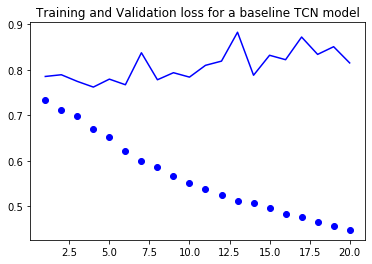

In [102]:
# Plotting Baseline Results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss,'b', label='Validation Loss')
plt.title("Training and Validation loss for a baseline TCN model")
plt.show()